In [2]:
pip install -q torch torchvision onnxruntime-gpu tqdm onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.3 MB/s eta 0:00:00


Альбументо-аугментации	Добейтесь ≥ 87 % accuracy на CIFAR-10 за 10 эпох. Сохраните accuracy_plot.png.

Device: cuda
Device: cuda
Training on cuda
Model parameters: 4,669,574
Trainable parameters: 3,817,766
Epoch  1/10 | Time: 142.1s | LR: 9.76e-05 | Train Loss: 3.3988 | Train Acc: 58.81% | Val Loss: 1.1440 | Val Acc: 84.78%
Epoch  2/10 | Time: 133.8s | LR: 9.05e-05 | Train Loss: 1.1365 | Train Acc: 81.75% | Val Loss: 0.8489 | Val Acc: 89.77%

🎯 Target accuracy of 87% reached at epoch 2!

Total training time: 4.6 minutes
Best validation accuracy: 89.77%


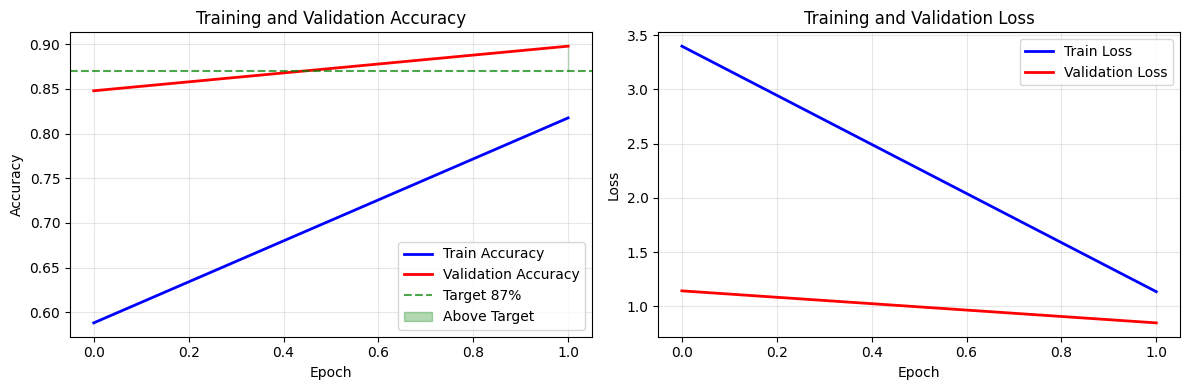


FINAL EVALUATION

Classification Report:
              precision    recall  f1-score   support

    airplane       0.90      0.90      0.90      1000
  automobile       0.97      0.92      0.94      1000
        bird       0.89      0.89      0.89      1000
         cat       0.87      0.75      0.80      1000
        deer       0.88      0.89      0.88      1000
         dog       0.83      0.88      0.86      1000
        frog       0.91      0.94      0.93      1000
       horse       0.91      0.94      0.93      1000
        ship       0.95      0.90      0.92      1000
       truck       0.88      0.96      0.92      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



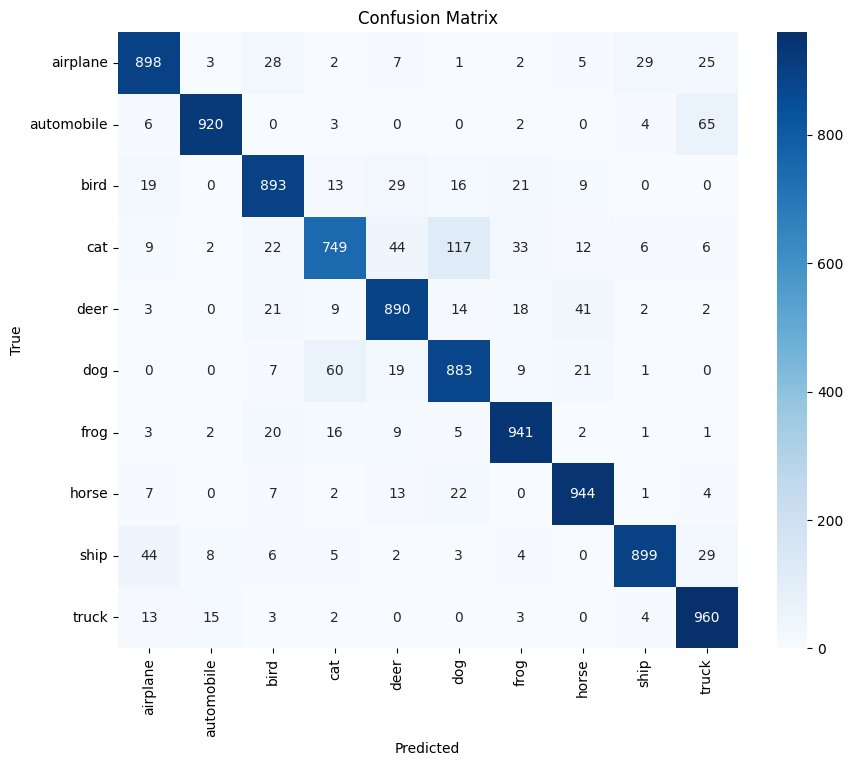

'\n# ================================================================\n# 7. Сравнение скорости инференса\n#    Будем прогонять 1000 батчей по 32 картинки = 32 000 изображений\n# ================================================================\ndef pytorch_inference_time(net, loader, batches=1000):\n    net.eval()\n    torch.cuda.synchronize()\n    t0 = time.time()\n    with torch.no_grad():\n        for i, (x, _) in enumerate(loader):\n            if i == batches: break\n            x = x.to(device)\n            _ = net(x)\n        torch.cuda.synchronize()\n    return time.time() - t0\n\ndef onnx_inference_time(sess, loader, batches=1000):\n    input_name  = sess.get_inputs()[0].name\n    torch.cuda.synchronize() if device.type=="cuda" else None\n    t0 = time.time()\n    for i, (x, _) in enumerate(loader):\n        if i == batches: break\n        x = x.numpy()\n        _ = sess.run(None, {input_name: x})\n    torch.cuda.synchronize() if device.type=="cuda" else None\n    return time.t

In [1]:
# ================================================================
# 1. Импорты и проверка устройства
# ================================================================
import torch, torchvision, time, onnx, onnxruntime, numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
# ================================================================
# 2. Преобразования и загрузка CIFAR-10
# ================================================================
if __name__ == "__main__":
    import torch
    import torchvision
    import torch.nn as nn
    import torch.optim as optim
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    import numpy as np
    import time
    import os

    # ======= НАСТРОЙКИ =======
    SEED = 42
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

    # ======= DEVICE =======
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # ======= АУГМЕНТАЦИЯ ДАННЫХ (КЛЮЧЕВОЕ ДЛЯ CIFAR-10) =======
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),  # Для EfficientNet
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1),  # Cutout-like augmentation
    ])

    val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # ======= ДАННЫЕ =======
    train_ds = datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform)
    val_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=val_transform)

    batch_size = 128
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size*2, shuffle=False, num_workers=2, pin_memory=True)

    # ======= МОДЕЛЬ С REGULARIZATION =======
    class CIFAR10Model(nn.Module):
        def __init__(self, num_classes=10):
            super().__init__()
            # Используем EfficientNet-B0 с предобученными весами
            self.backbone = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)

            # Замораживаем часть слоев для стабильности
            for param in self.backbone.parameters():
                param.requires_grad = False
            # Размораживаем последние слои
            for param in self.backbone.features[-3:].parameters():
                param.requires_grad = True
            for param in self.backbone.classifier.parameters():
                param.requires_grad = True

            # Добавляем дополнительные слои для CIFAR-10
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Sequential(
                nn.Dropout(0.3),  # Dropout для регуляризации
                nn.Linear(in_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, num_classes)
            )

            # Инициализация весов
            self._initialize_weights()

        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)

        def forward(self, x):
            return self.backbone(x)

    model = CIFAR10Model().to(device)

    # ======= ОПТИМИЗАТОР И SCHEDULER =======
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing для лучшего обобщения

    # Разные learning rates для разных слоев
    optimizer = optim.AdamW([
        {'params': model.backbone.features[-3:].parameters(), 'lr': 1e-4},
        {'params': model.backbone.classifier.parameters(), 'lr': 3e-4}
    ], weight_decay=1e-4)

    # Cosine annealing scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

    # ======= FUNCTIONS =======
    def train_epoch(model, loader, criterion, optimizer, device):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for x, y in loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()

            # Gradient clipping для стабильности
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item() * x.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)

        return total_loss / total, correct / total

    def validate(model, loader, criterion, device):
        model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)

                total_loss += loss.item() * x.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(y).sum().item()
                total += y.size(0)

        return total_loss / total, correct / total

    # ======= ОБУЧЕНИЕ =======
    epochs = 10
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    print(f"Training on {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    start_time = time.time()
    best_val_acc = 0.0

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()

        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Валидация
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Обновление learning rate
        scheduler.step()

        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_model.pth')

        epoch_time = time.time() - epoch_start

        print(f"Epoch {epoch:2d}/{epochs} | "
              f"Time: {epoch_time:.1f}s | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:5.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:5.2f}%")

        # Ранняя остановка при достижении цели
        if val_acc >= 0.87:
            print(f"\n🎯 Target accuracy of 87% reached at epoch {epoch}!")
            break

    total_time = time.time() - start_time
    print(f"\nTotal training time: {total_time/60:.1f} minutes")
    print(f"Best validation accuracy: {best_val_acc*100:.2f}%")

    # ======= ВИЗУАЛИЗАЦИЯ =======
    plt.figure(figsize=(12, 4))

    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, 'b-', label='Train Accuracy', linewidth=2)
    plt.plot(val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    plt.axhline(y=0.87, color='g', linestyle='--', label='Target 87%', alpha=0.7)
    plt.fill_between(range(len(val_accs)), 0.87, val_accs, where=(np.array(val_accs) >= 0.87),
                     color='green', alpha=0.3, label='Above Target')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(val_losses, 'r-', label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('accuracy_plot.png', dpi=150, bbox_inches='tight')
    plt.show()

    # ======= ТЕСТИРОВАНИЕ =======
    print("\n" + "="*50)
    print("FINAL EVALUATION")
    print("="*50)

    # Загружаем лучшую модель
    checkpoint = torch.load('best_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Финальная оценка
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            outputs = model(x)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.numpy())

    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=[
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer',
                            'dog', 'frog', 'horse', 'ship', 'truck'],
                yticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer',
                            'dog', 'frog', 'horse', 'ship', 'truck'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
